In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle
import re
import os
import glob

import sys
sys.path.append('../')
from scib import Plotter

plt.rcParams["font.size"] = 18

In [33]:
log_categories = {
    'adv': {
        'columns': ['time', 'addr'],
        'dtypes': [int, str],
        'pattern': r'00> (\d{10}),a,([0-9a-zA-Z]{2}:[0-9a-zA-Z]{2}:[0-9a-zA-Z]{2}:[0-9a-zA-Z]{2}:[0-9a-zA-Z]{2}:[0-9a-zA-Z]{2})*'
    },
    'connected': {
        'columns': ['time', 'conn_handle', 'addr'],
        'dtypes': [int, int, str],
        'pattern': r'00> (\d{10}),c,(\d+),([0-9a-zA-Z]{2}:[0-9a-zA-Z]{2}:[0-9a-zA-Z]{2}:[0-9a-zA-Z]{2}:[0-9a-zA-Z]{2}:[0-9a-zA-Z]{2})*'
    },
    'disconnected': {
        'columns': ['time', 'cmu_index', 'addr'],
        'dtypes': [int, int, str],
        'pattern': r'00> (\d{10}),d,(\d+),([0-9a-zA-Z]{2}:[0-9a-zA-Z]{2}:[0-9a-zA-Z]{2}:[0-9a-zA-Z]{2}:[0-9a-zA-Z]{2}:[0-9a-zA-Z]{2})*'
    },
    'vs': {
        'columns': ['time', 'conn_handle', 'cc'],
        'dtypes': [int, int, int],
        'pattern': r'00> (\d{10}),v,(\d+),(\d+$)'
    },
    'qos': {
        'columns': ['time', 'conn_handle', 'channel_index', 'event_counter', 'crc_ok_count', 'crc_error_count', 'nak_count', 'rx_timeout', 'rssi'],
        'dtypes': [int, int, int, int, int, int, int, int, int],
        'pattern': r'00> (\d{10}),q,(\d+),(\d+),(\d{6}),(\d+),(\d+),(\d+),(\d+),(-\d+$)'
    }
}

In [34]:
log_dir = 'log'
log_files = {
    'g1': '20230413-1544-bmu.log',
    # 'g2': '20230214_183443_COM42.log',
    # 'g3': '20230214_183508_COM56.log',
    # 'g4': '20230214_183512_COM57.log'
}
dfs = {}
for group in log_files.keys():
    dfs[group] = {}

In [35]:
dfs_filename = os.path.join(log_dir, 'dfs.pickle')

if os.path.isfile(dfs_filename):
    with open(dfs_filename, 'rb') as f:
        dfs = pickle.load(f)
        print('dfs has been loaded.')
else:
    for group, filename in log_files.items():
        print(group)
        with open(os.path.join(log_dir, filename)) as f:
            lines = f.readlines()
            for df_name, info in log_categories.items():
                repatter = re.compile(info['pattern'])
                match_lines = [repatter.match(l).groups() for l in lines if repatter.match(l)]
                dfs[group][df_name] = pd.DataFrame(match_lines, columns=info['columns'], dtype=str)
                for column, dtype in zip(info['columns'], info['dtypes']):
                    dfs[group][df_name][column] = dfs[group][df_name][column].astype(dtype)
                dfs[group][df_name]['timedelta'] = dfs[group][df_name]['time'].apply(lambda x: datetime.timedelta(milliseconds=x))
                dfs[group][df_name].set_index('timedelta')
    with open(dfs_filename, 'wb') as f:
        pickle.dump(dfs, f)
        print('dfs has been dumped.')

g1
dfs has been dumped.


In [36]:
# Check the duration in hours
for group in dfs.keys():
    print(group, datetime.timedelta(milliseconds=dfs[group]['vs']['time'].max().item()))

g1 0:20:17.944000


In [37]:
n_cmu = 0
for group in dfs.keys():
    n_cmu = max(n_cmu, len(dfs[group]['connected']['conn_handle'].unique()))
n_cmu

1

In [38]:
dfs['g1']['qos']

,time,conn_handle,channel_index,event_counter,crc_ok_count,crc_error_count,nak_count,rx_timeout,rssi,timedelta
0,958984,0,3,15801,1,0,0,0,-45,0 days 00:15:58.984000
1,959044,0,10,15802,1,0,0,0,-45,0 days 00:15:59.044000
2,959104,0,34,15803,1,0,0,0,-45,0 days 00:15:59.104000
3,959164,0,5,15804,1,0,0,0,-44,0 days 00:15:59.164000
4,959224,0,19,15805,1,0,0,0,-47,0 days 00:15:59.224000
...,...,...,...,...,...,...,...,...,...,...
3551,1217824,0,2,20115,1,0,0,0,-61,0 days 00:20:17.824000
3552,1217884,0,14,20116,1,0,0,0,-61,0 days 00:20:17.884000
3553,1217944,0,10,20117,1,0,0,0,-64,0 days 00:20:17.944000
3554,1218004,0,36,20118,1,0,0,0,-56,0 days 00:20:18.004000


In [39]:
dfs['g1']['qos']


,time,conn_handle,channel_index,event_counter,crc_ok_count,crc_error_count,nak_count,rx_timeout,rssi,timedelta
0,958984,0,3,15801,1,0,0,0,-45,0 days 00:15:58.984000
1,959044,0,10,15802,1,0,0,0,-45,0 days 00:15:59.044000
2,959104,0,34,15803,1,0,0,0,-45,0 days 00:15:59.104000
3,959164,0,5,15804,1,0,0,0,-44,0 days 00:15:59.164000
4,959224,0,19,15805,1,0,0,0,-47,0 days 00:15:59.224000
...,...,...,...,...,...,...,...,...,...,...
3551,1217824,0,2,20115,1,0,0,0,-61,0 days 00:20:17.824000
3552,1217884,0,14,20116,1,0,0,0,-61,0 days 00:20:17.884000
3553,1217944,0,10,20117,1,0,0,0,-64,0 days 00:20:17.944000
3554,1218004,0,36,20118,1,0,0,0,-56,0 days 00:20:18.004000


In [40]:
group_handle2addr = {}
for group in dfs.keys():
    group_handle2addr[group] = {}
    for conn_handle in range(n_cmu):
        group_handle2addr[group][conn_handle] = dfs[group]['connected'].query('conn_handle==@conn_handle').iloc[-1]['addr']
group_handle2addr

{'g1': {0: 'F8:57:E6:87:B8:2C'}}

In [41]:
datetime.timedelta(minutes=30).total_seconds() * 1000

1800000.0

In [42]:
# Remove first 30 minutes and leave 8 hours data
# for group, df_group in dfs.items():
#     for category, df in df_group.items():
#         time_start = datetime.timedelta(minutes=30).total_seconds() * 1000
#         time_end = time_start + datetime.timedelta(hours=8).total_seconds() * 1000
#         dfs[group][category] = df.query('@time_start < time < @time_end').reset_index(drop=True)

In [43]:
# Check the duration in hours
for group in dfs.keys():
    print(group, datetime.timedelta(milliseconds=dfs[group]['vs']['time'].max().item()))

g1 0:20:17.944000


In [44]:
# Check the number of conn handle
for group in dfs.keys():
    print(group, len(dfs[group]['vs']['conn_handle'].unique()))

g1 1


In [45]:
for group in dfs.keys():
    for conn_handle in range(n_cmu):
        dfs[group]['vs'].loc[dfs[group]['vs']['conn_handle']==conn_handle, 'delayed'] = dfs[group]['vs'].query('conn_handle==@conn_handle')['time'].diff()>150
        dfs[group]['vs'].loc[dfs[group]['vs']['conn_handle']==conn_handle, 'delayed'] = dfs[group]['vs'].loc[dfs[group]['vs']['conn_handle']==conn_handle, 'delayed'].astype(float)

In [46]:
# Check the number of disconnection
for group in dfs.keys():
    print(group, len(dfs[group]['disconnected']))

g1 0


## Analysis 



In [47]:
dfs['g1']['qos']['channel_index'].max()

36

In [48]:
dfs['g1']['qos'][['crc_ok_count', 'crc_error_count']].drop_duplicates()

,crc_ok_count,crc_error_count
0,1,0
9,0,0
262,2,0
478,0,1


In [49]:
dfs['g1']['qos']

,time,conn_handle,channel_index,event_counter,crc_ok_count,crc_error_count,nak_count,rx_timeout,rssi,timedelta
0,958984,0,3,15801,1,0,0,0,-45,0 days 00:15:58.984000
1,959044,0,10,15802,1,0,0,0,-45,0 days 00:15:59.044000
2,959104,0,34,15803,1,0,0,0,-45,0 days 00:15:59.104000
3,959164,0,5,15804,1,0,0,0,-44,0 days 00:15:59.164000
4,959224,0,19,15805,1,0,0,0,-47,0 days 00:15:59.224000
...,...,...,...,...,...,...,...,...,...,...
3551,1217824,0,2,20115,1,0,0,0,-61,0 days 00:20:17.824000
3552,1217884,0,14,20116,1,0,0,0,-61,0 days 00:20:17.884000
3553,1217944,0,10,20117,1,0,0,0,-64,0 days 00:20:17.944000
3554,1218004,0,36,20118,1,0,0,0,-56,0 days 00:20:18.004000


In [50]:
dfs['g1']['qos']['crc_error_count'].sum()

5

In [51]:
dfs['g1']['qos'].query('channel_index==0')

,time,conn_handle,channel_index,event_counter,crc_ok_count,crc_error_count,nak_count,rx_timeout,rssi,timedelta
15,1005664,0,0,16579,1,0,0,0,-56,0 days 00:16:45.664000
55,1008064,0,0,16619,0,0,0,1,-52,0 days 00:16:48.064000
117,1011784,0,0,16681,1,0,0,0,-51,0 days 00:16:51.784000
164,1014604,0,0,16728,1,0,0,0,-50,0 days 00:16:54.604000
249,1019704,0,0,16813,1,0,0,0,-54,0 days 00:16:59.704000
...,...,...,...,...,...,...,...,...,...,...
3396,1208524,0,0,19960,1,0,0,0,-55,0 days 00:20:08.524000
3404,1209004,0,0,19968,1,0,0,0,-55,0 days 00:20:09.004000
3408,1209244,0,0,19972,1,0,0,0,-55,0 days 00:20:09.244000
3450,1211764,0,0,20014,1,0,0,0,-55,0 days 00:20:11.764000


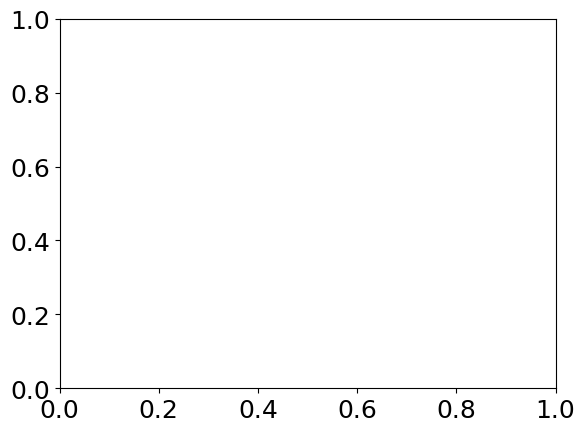

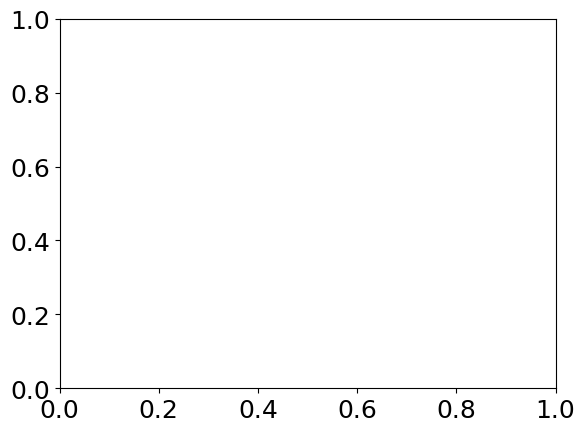

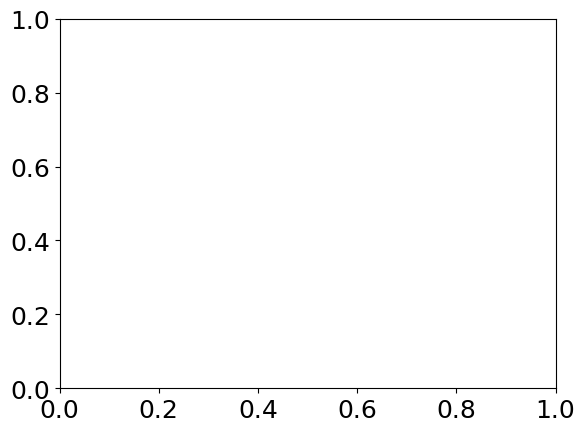

In [52]:
for i in range(3):
    fig = plt.figure()
    ax = fig.add_subplot()
    plt.show()

Error in callback <function _draw_all_if_interactive at 0x000001733F849630> (for post_execute):


KeyboardInterrupt: 

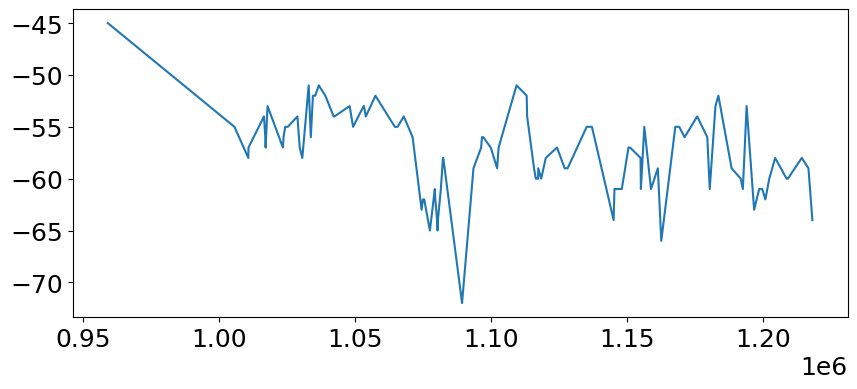

In [53]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot()
df=dfs['g1']['qos'].query('channel_index==3')
x=df['time']
y=df['rssi']
ax.plot(x, y)

In [55]:
for group in dfs.keys():
    dfs[group]['qos']['result'] = pd.Series(dtype=str)
    dfs[group]['qos'].loc[(dfs[group]['qos']['crc_ok_count']==0) & (dfs[group]['qos']['crc_error_count']==0), 'result'] = 'not arrived'
    dfs[group]['qos'].loc[(dfs[group]['qos']['crc_ok_count']>0), 'result'] = 'ok'
    dfs[group]['qos'].loc[(dfs[group]['qos']['crc_error_count']>0), 'result'] = 'error'

g1	0	max delay:46080.0(ms)	max delay(qos):45840.0(ms)	

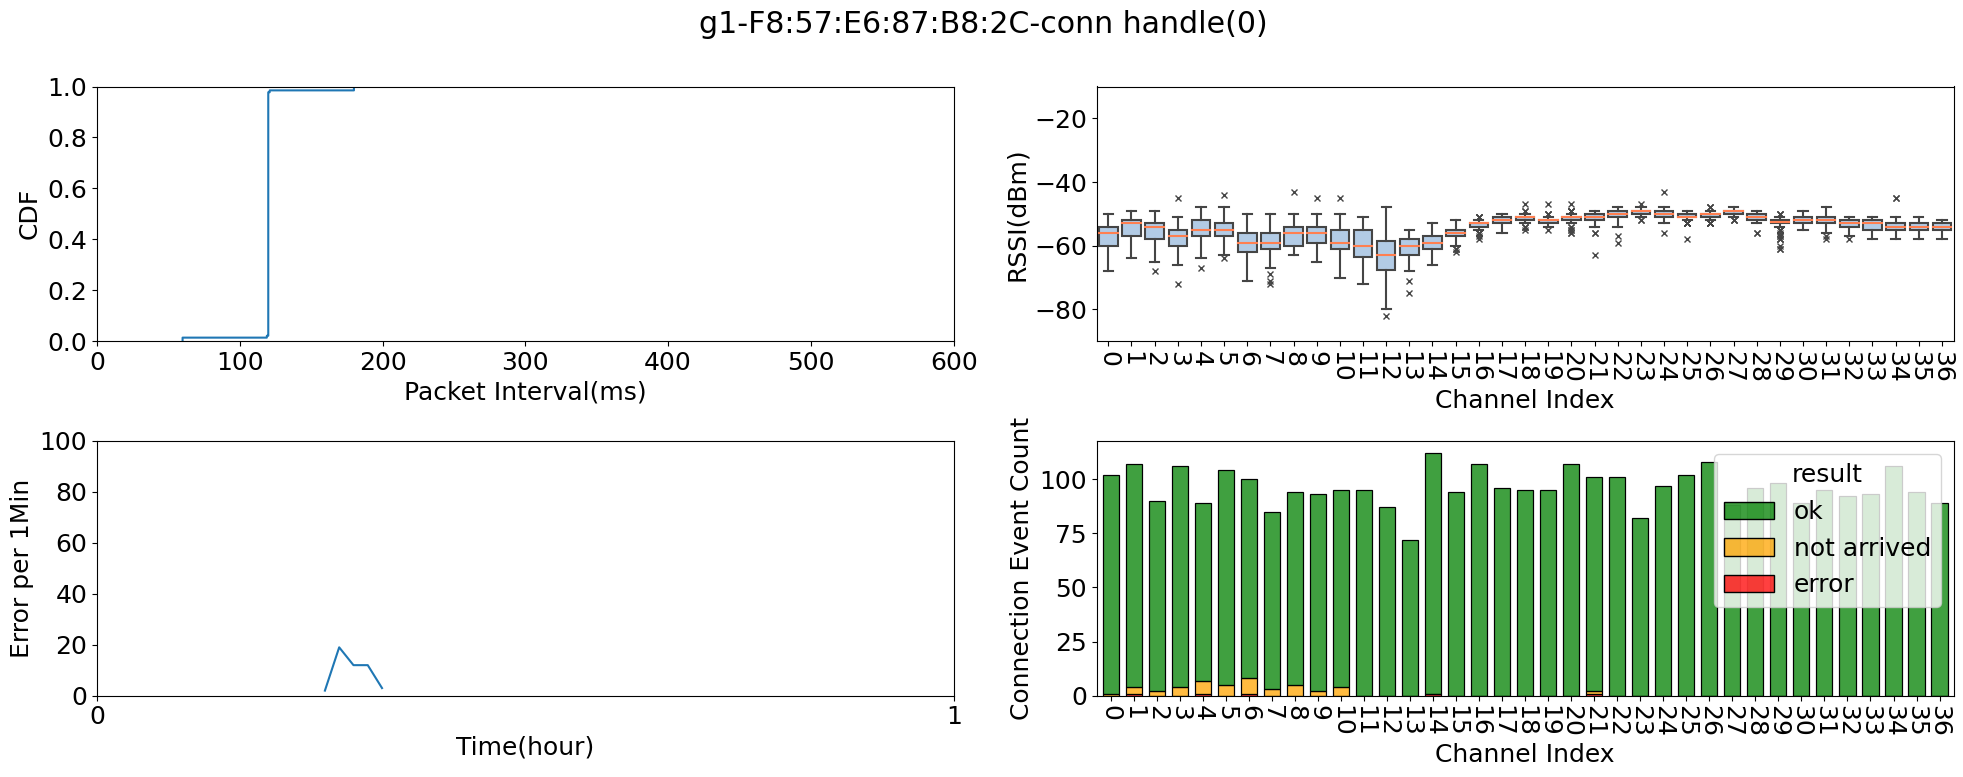

In [56]:
# delay check
for group, df_group in dfs.items():
    for conn_handle, addr in sorted(group_handle2addr[group].items(), key=lambda x: x[1]):
        print(group, end='\t')
        print(conn_handle, end='\t')
        df_diff = df_group['vs'].query('conn_handle==@conn_handle')['time'].diff().iloc[1:, ]
        print(f'max delay:{df_diff.max()}(ms)', end='\t')
        # print(f'delay prob:{len(df_diff[df_diff>150])/len(df_diff):.5e}')
        df_diff_qos = df_group['qos'].query('conn_handle==@conn_handle')['time'].diff().iloc[1:, ]
        print(f'max delay(qos):{df_diff_qos.max()}(ms)', end='\t')

        fig = plt.figure(figsize=(20, 8))
        fig.suptitle(f'{group}-{addr}-conn handle({conn_handle})')
        ax1 = fig.add_subplot(2, 2, 1)
        Plotter.ecdf(df_group['vs'], conn_handle, ax1)

        ax2 = fig.add_subplot(2, 2, 2)
        Plotter.rssi_box(df_group['qos'], conn_handle, ax2)

        ax3 = fig.add_subplot(2,2,3)
        Plotter.delay_transition_qos(df_group['qos'], conn_handle, ax3, ylim=(0, 100))
        # Plotter.delay_transition(df_group['vs'], conn_handle, ax3)

        ax4 = fig.add_subplot(2, 2, 4)
        Plotter.crc_hist(df_group['qos'], conn_handle, ax4)

        plt.tight_layout()
        plt.show()

        list(df_group['qos'][df_group['qos']['conn_handle'] == conn_handle]['channel_index'].unique())
        print()

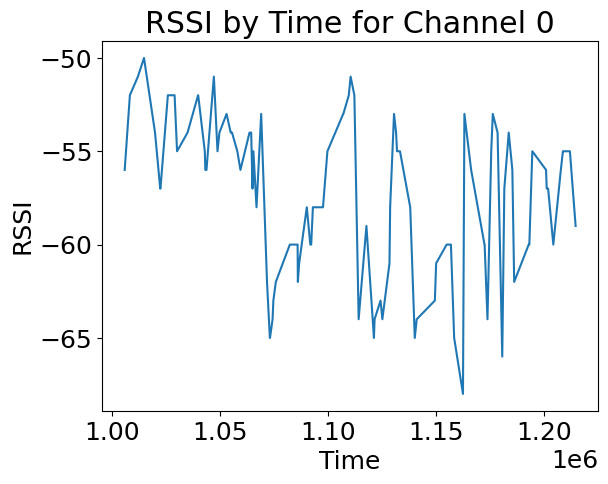

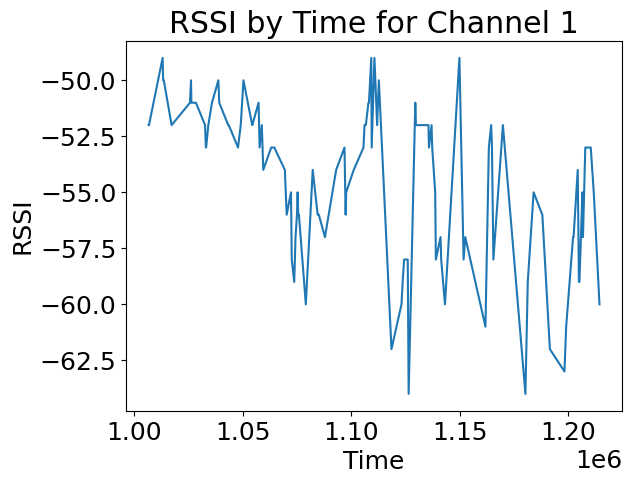

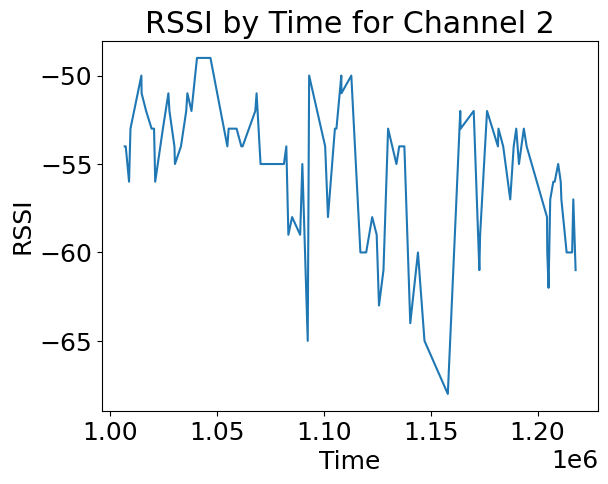

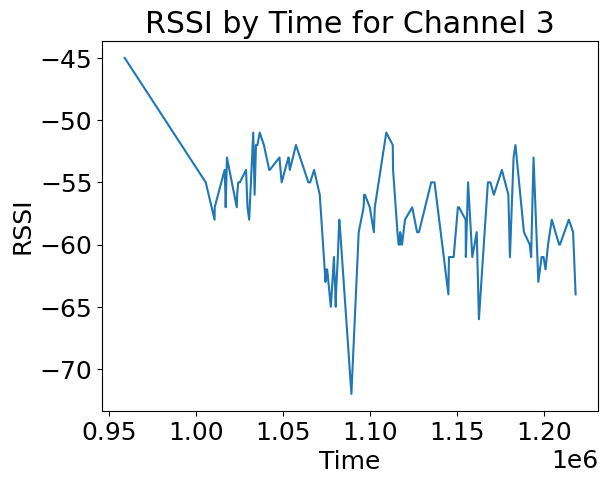

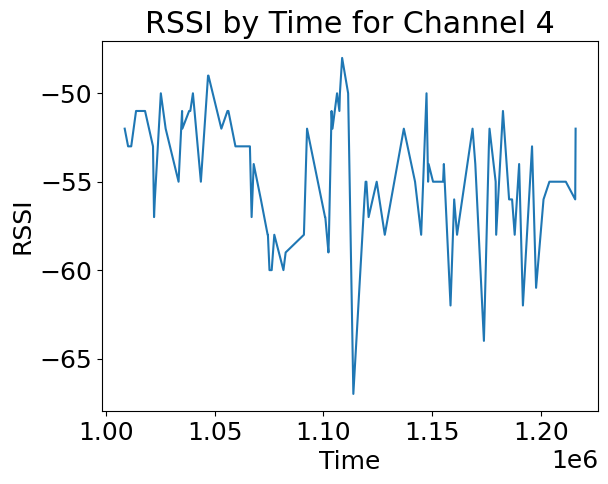

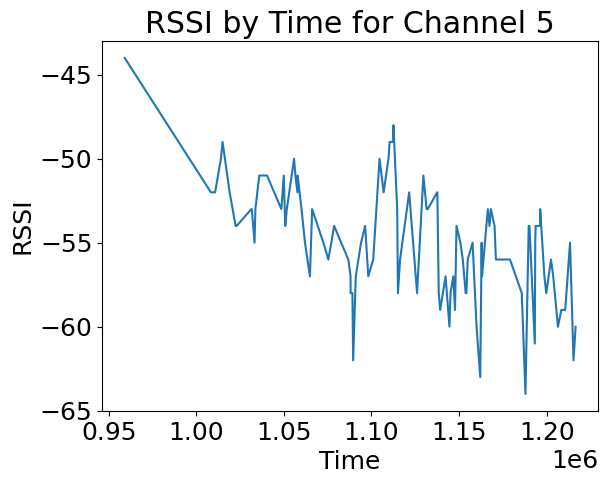

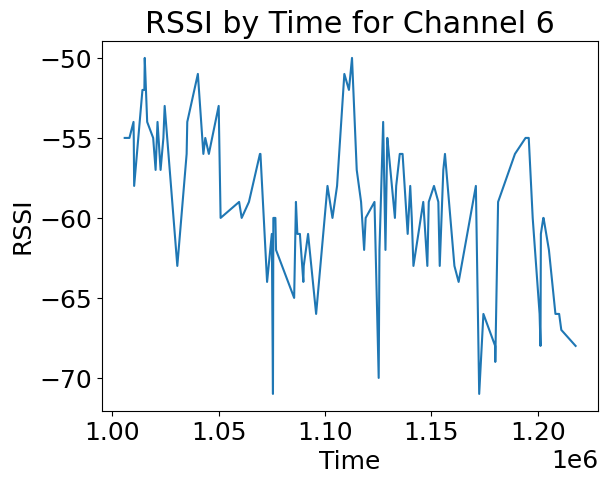

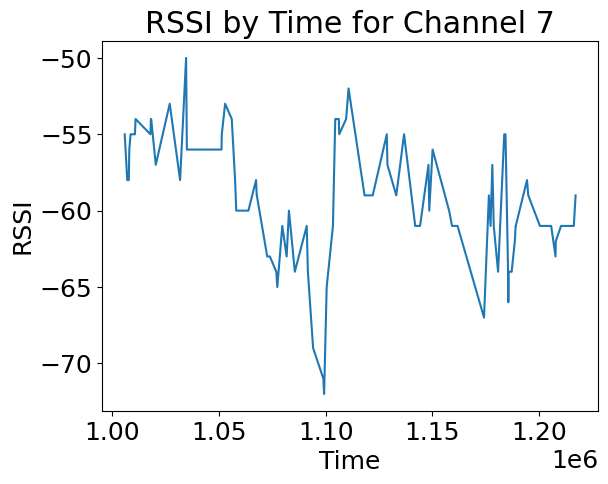

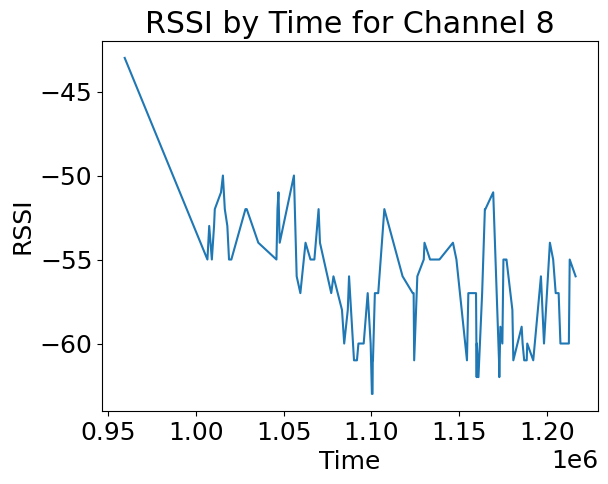

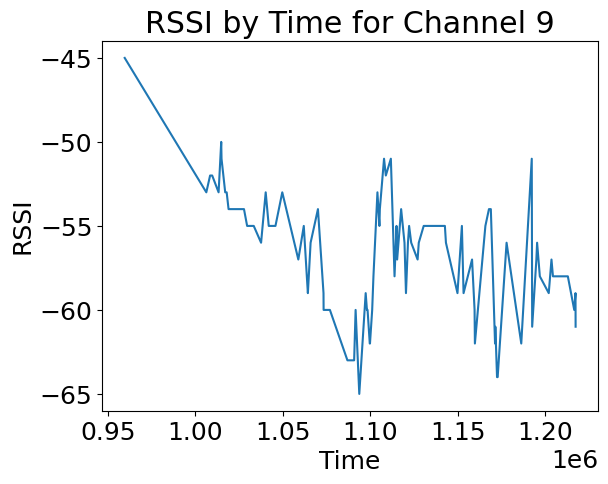

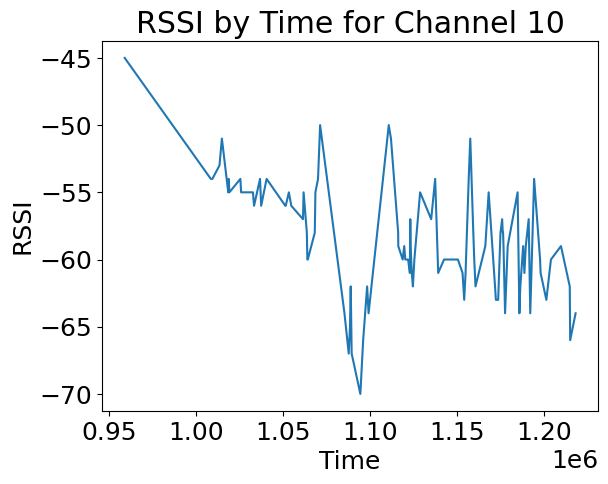

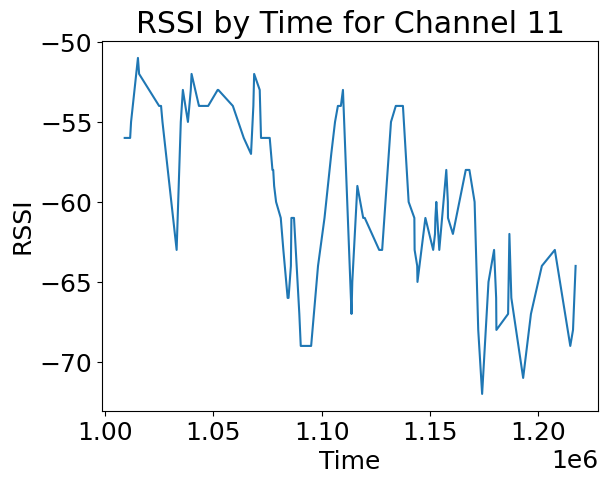

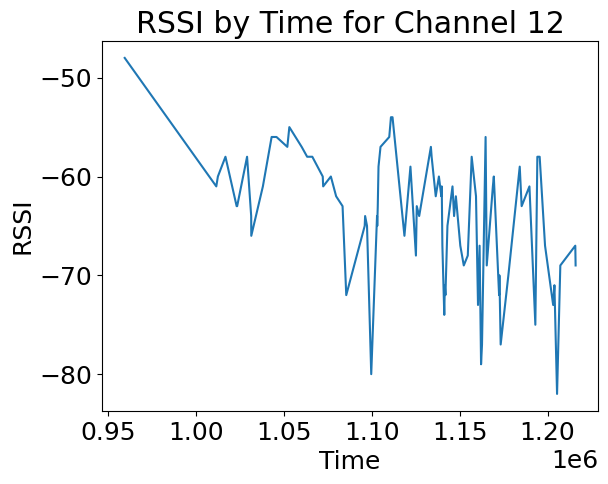

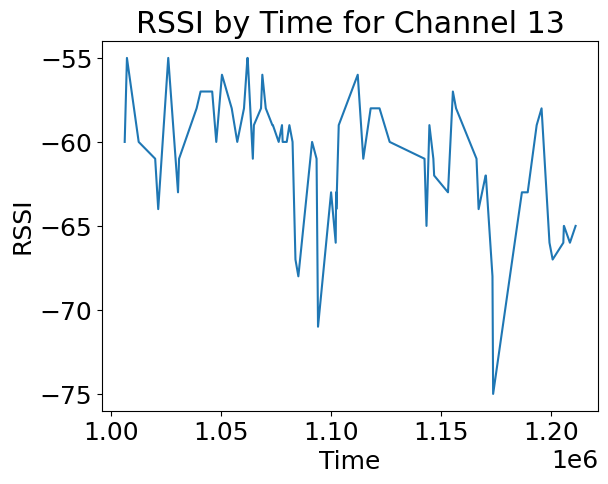

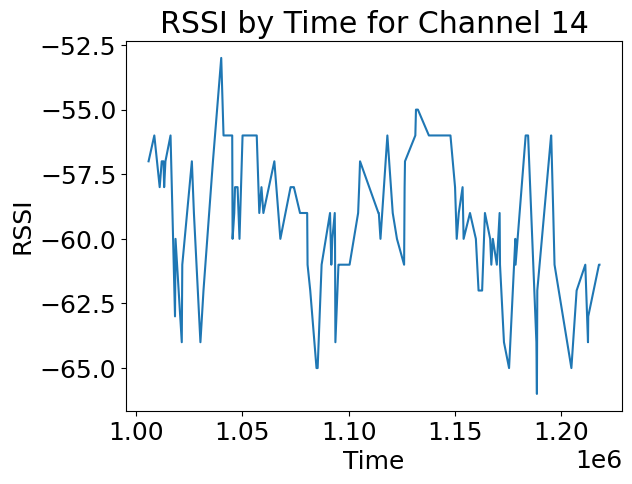

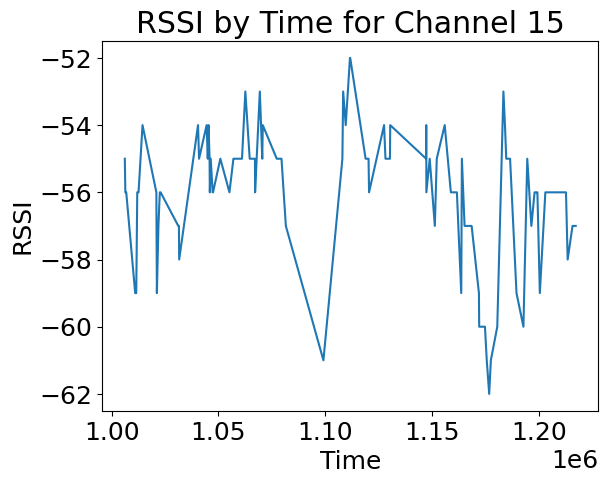

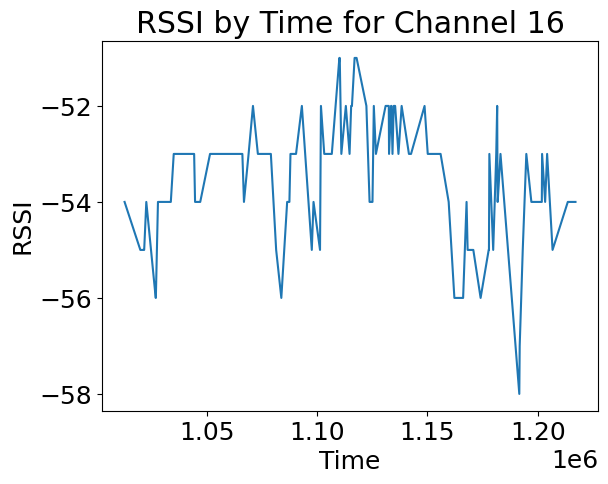

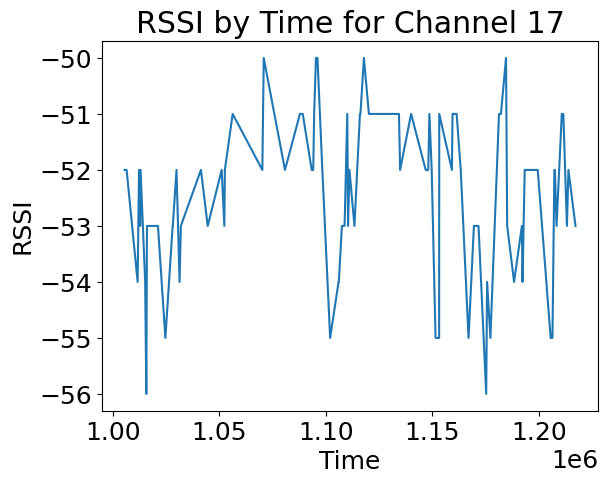

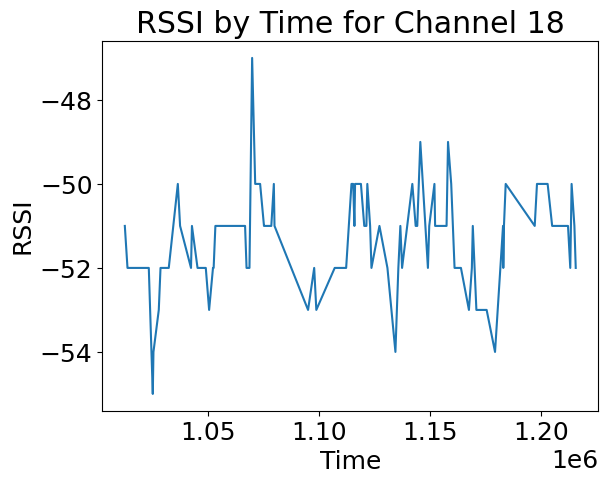

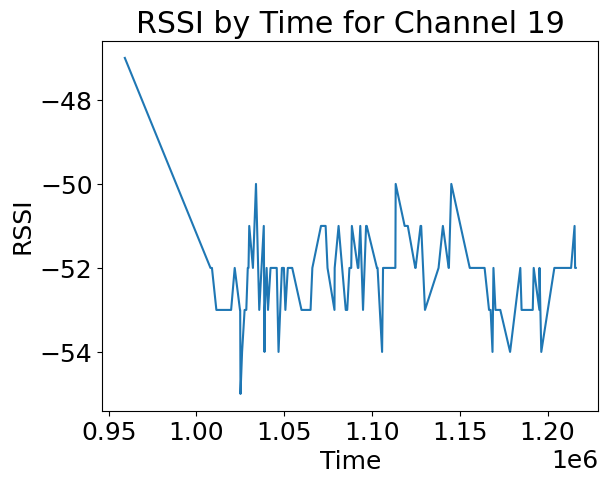

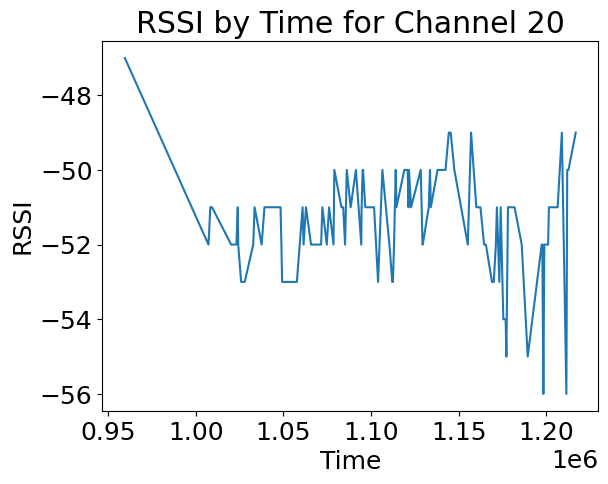

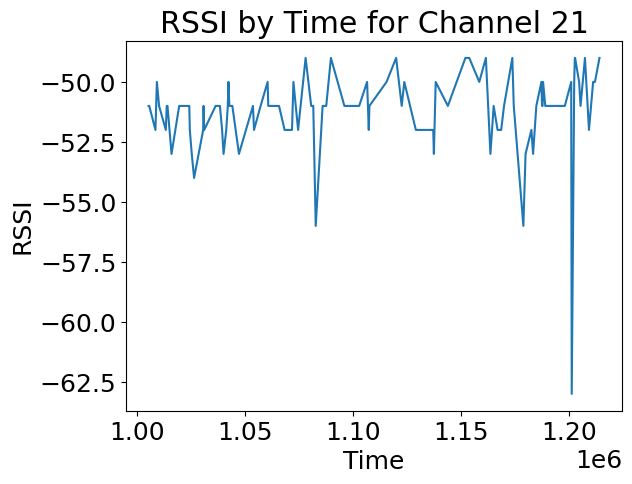

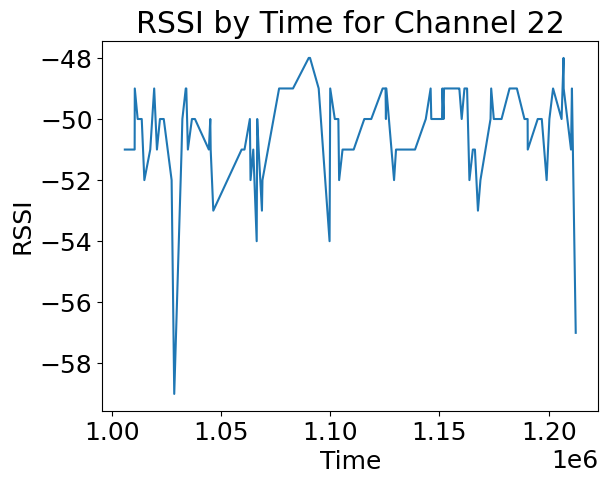

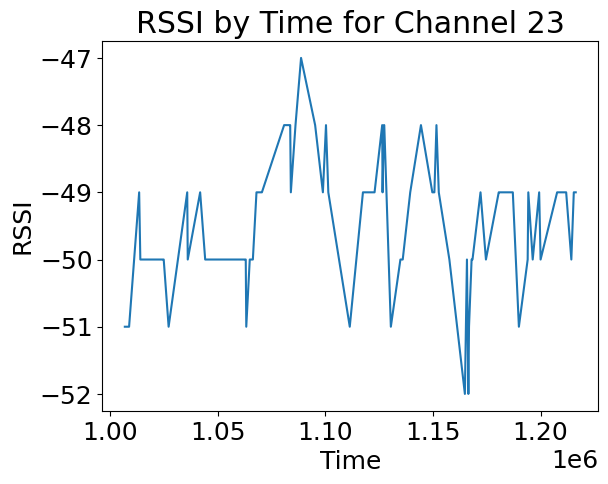

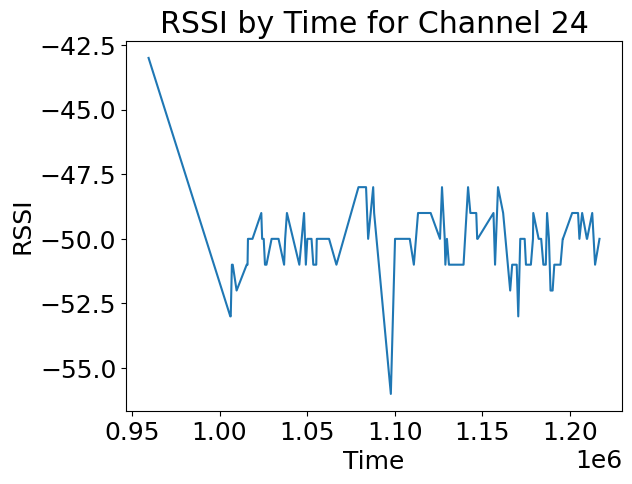

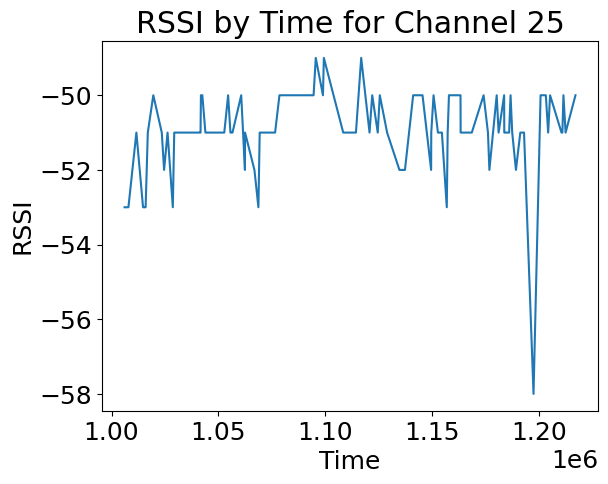

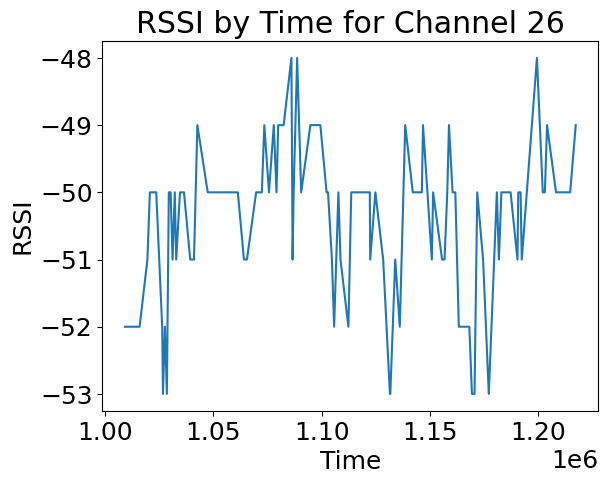

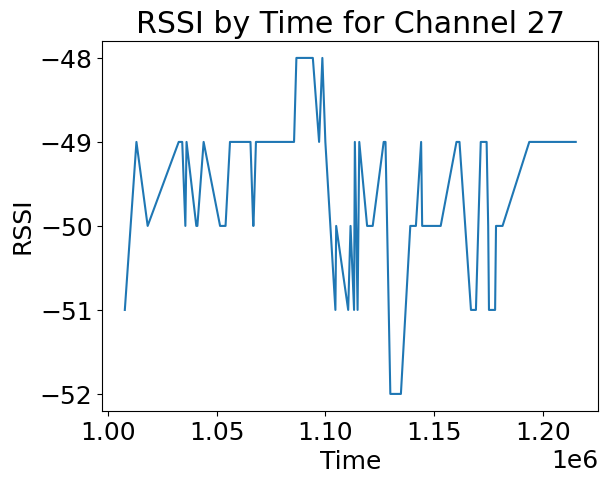

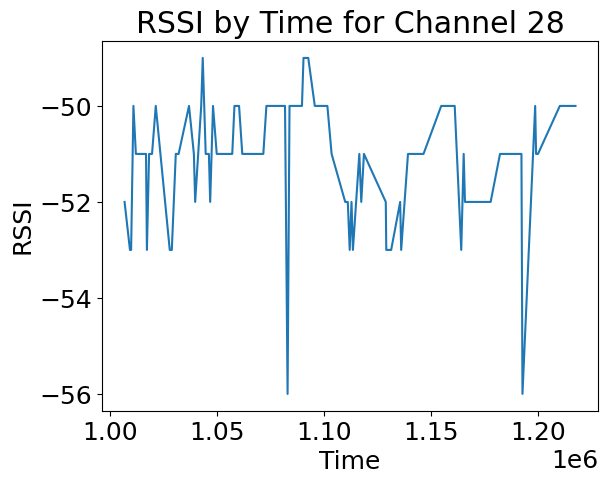

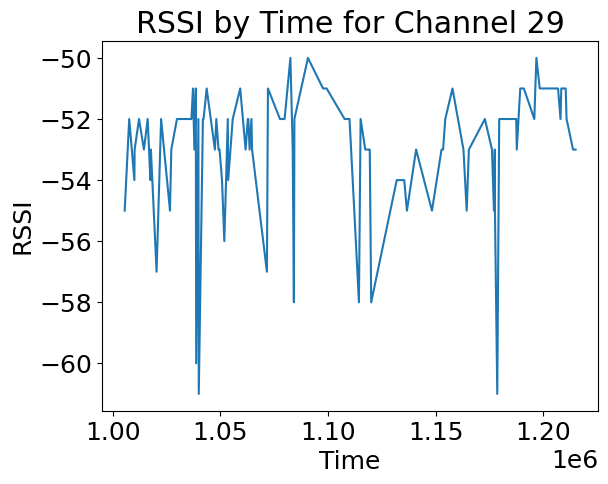

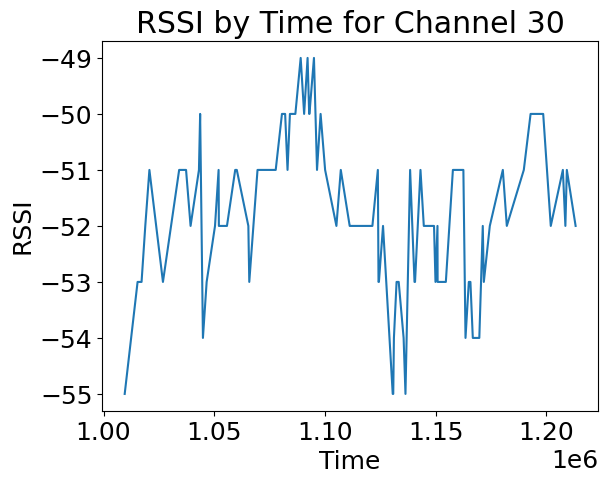

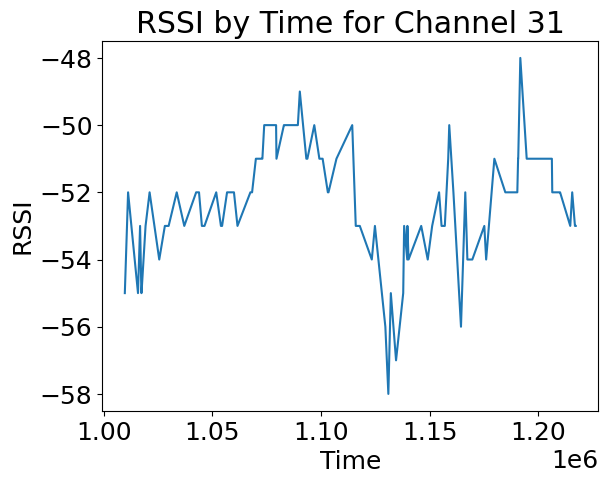

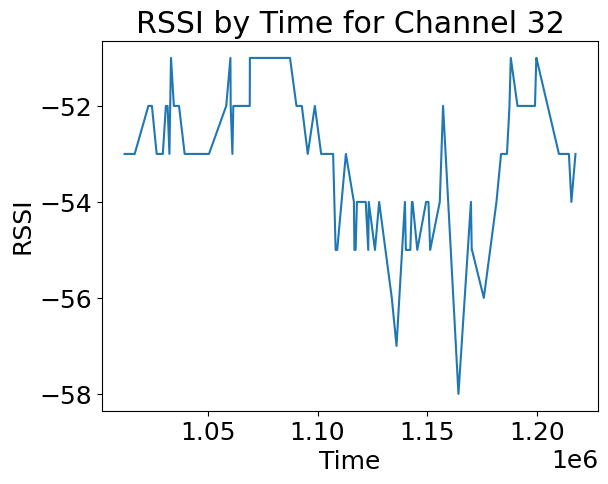

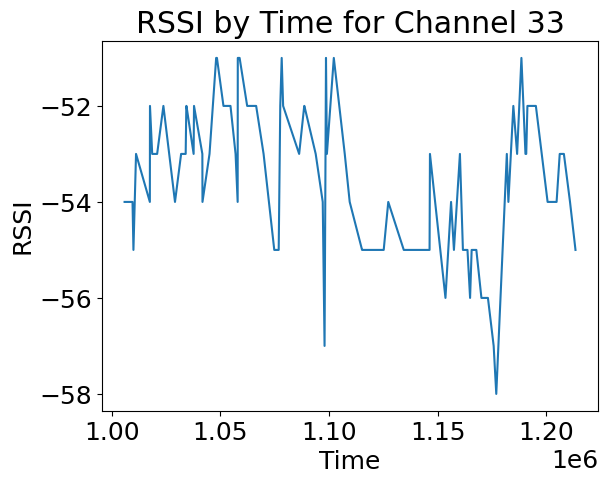

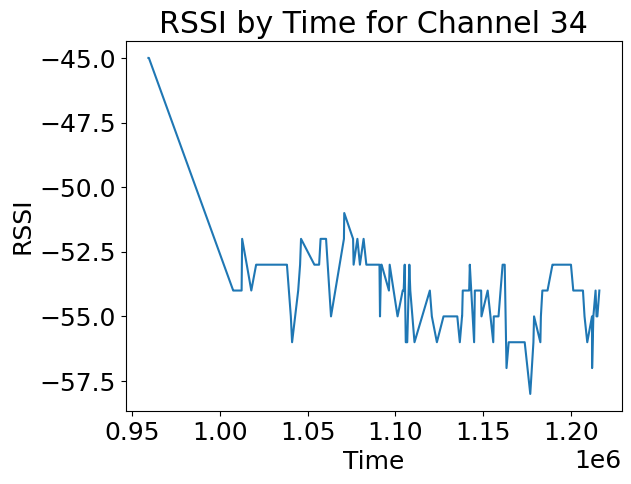

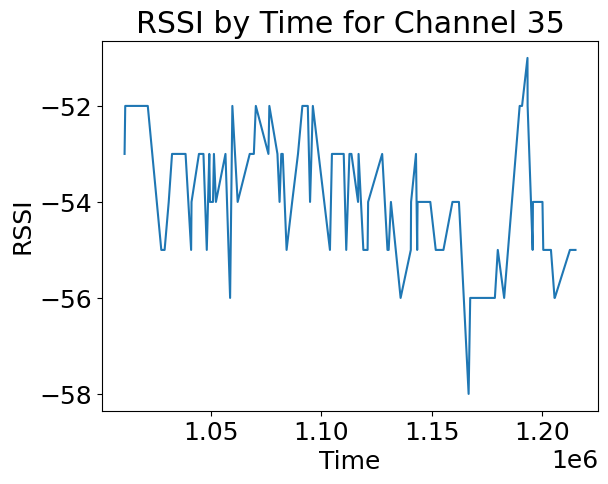

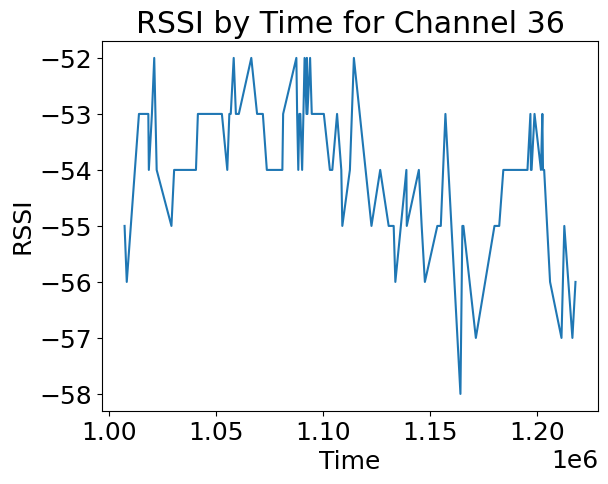

In [ ]:
# Group data by channel number
grouped_data = dfs['g1']['qos'].groupby('channel_index')

# Plot RSSI by time for each channel
for channel, group in grouped_data:
    plt.plot(group['time'], group['rssi'])
    plt.title('RSSI by Time for Channel {}'.format(channel))
    plt.xlabel('Time')
    plt.ylabel('RSSI')
    plt.show()

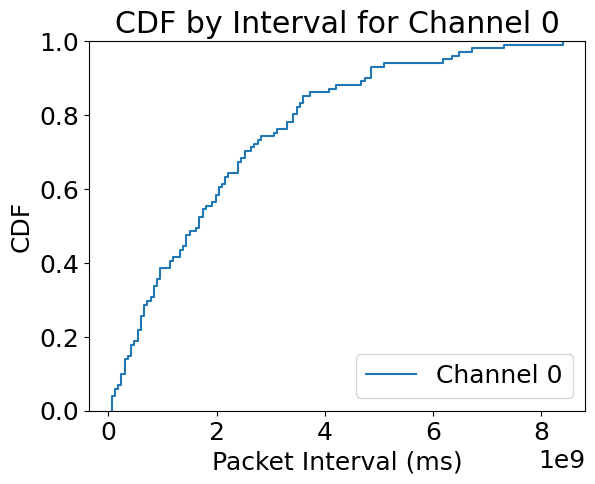

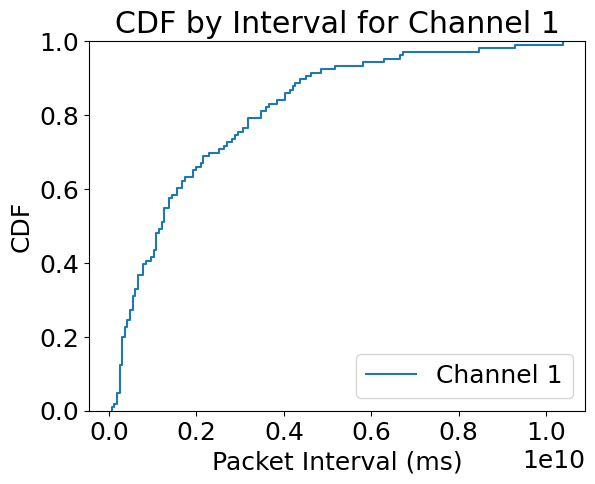

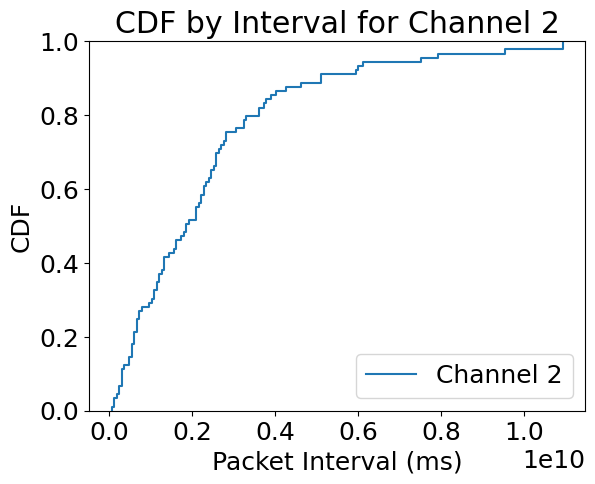

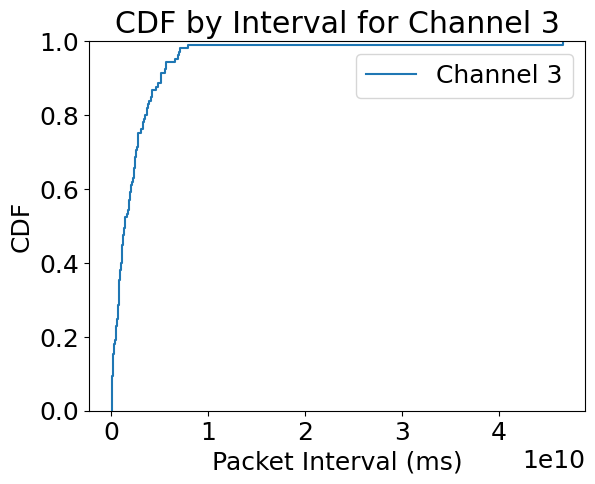

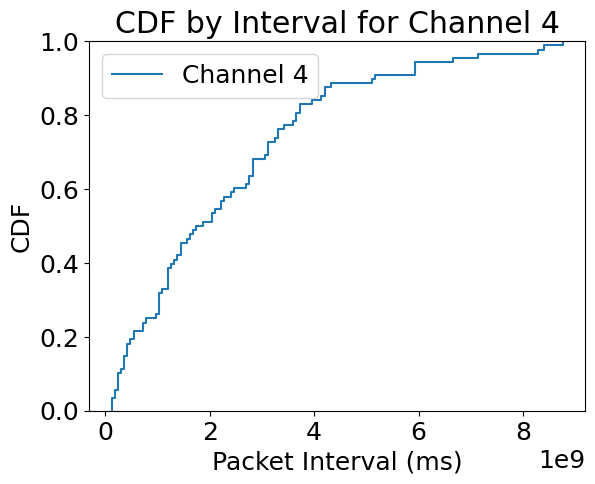

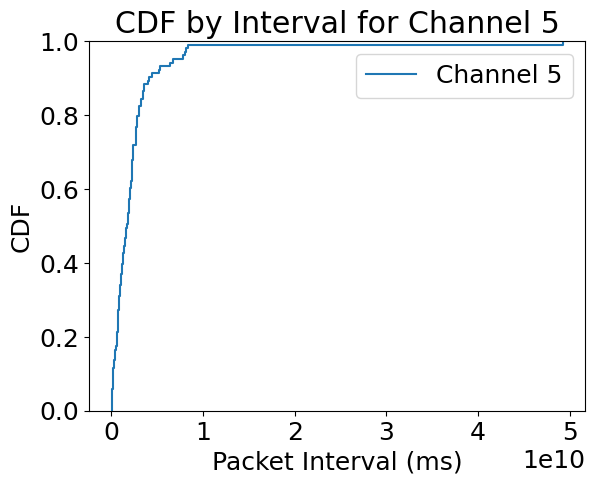

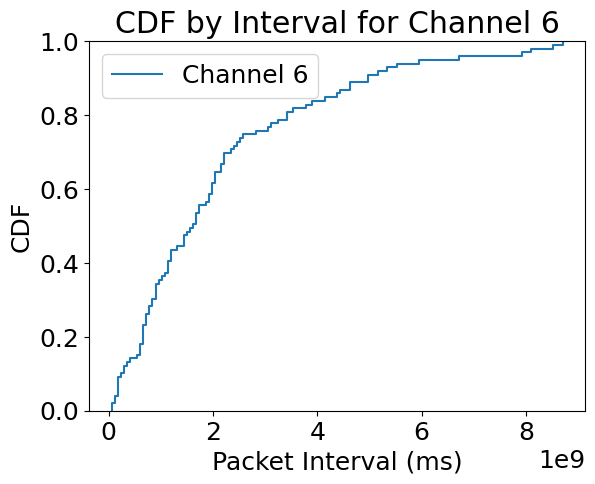

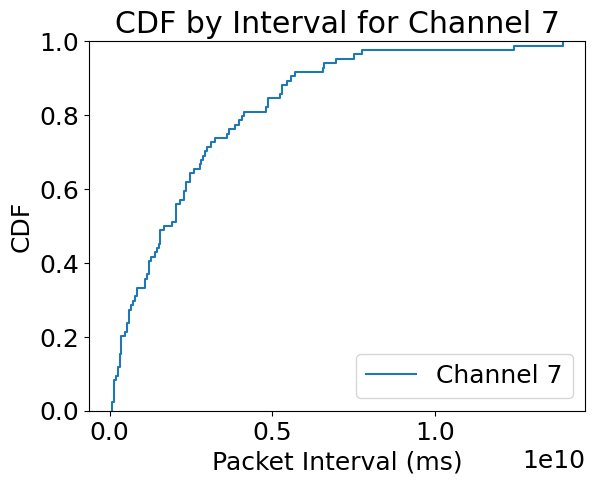

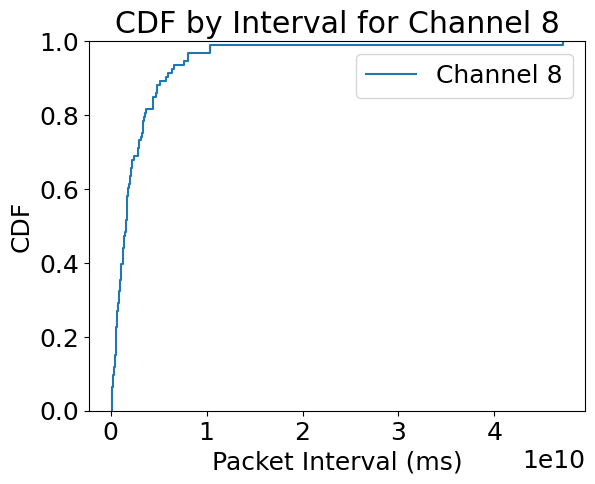

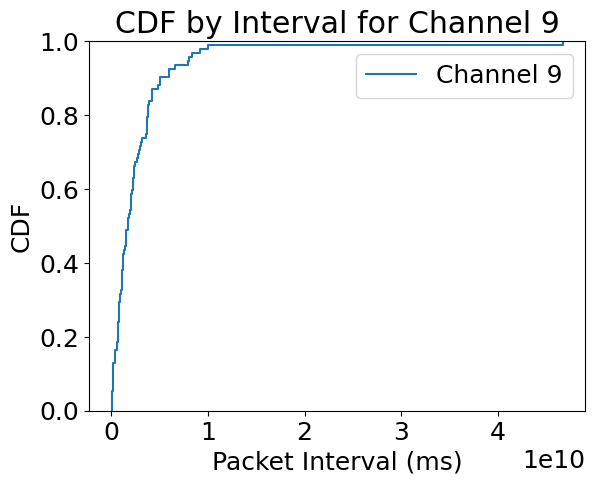

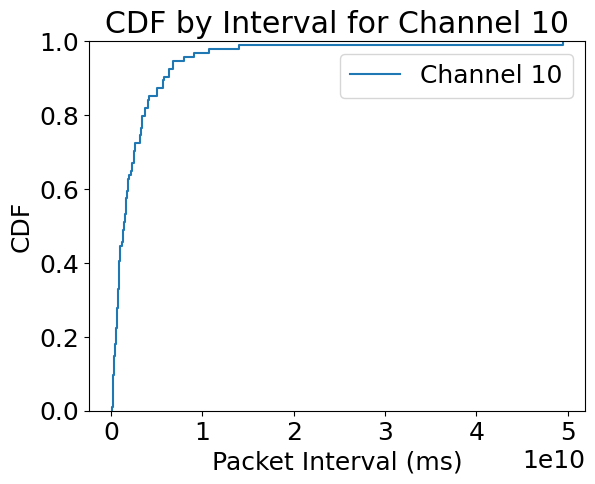

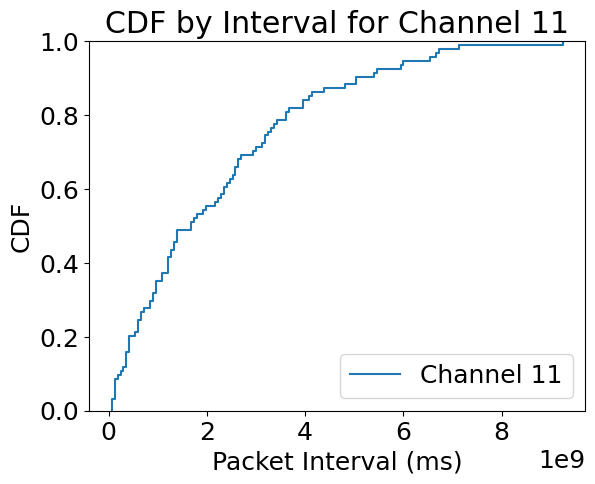

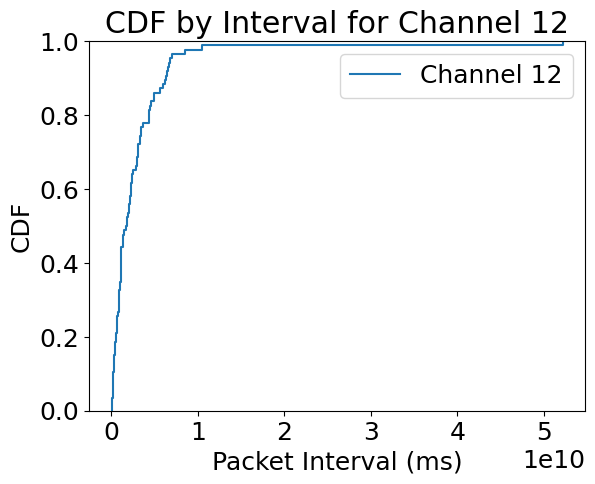

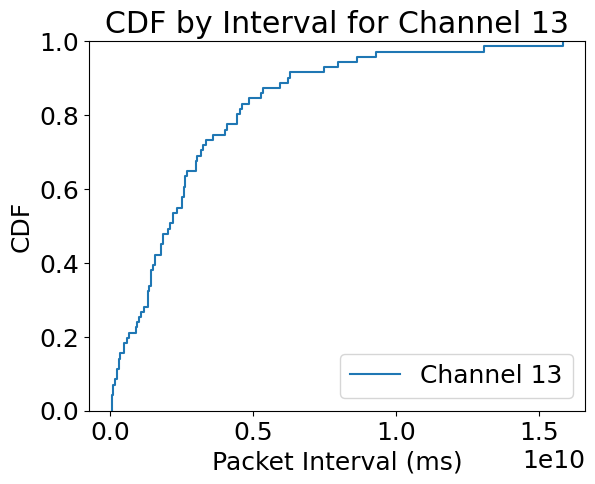

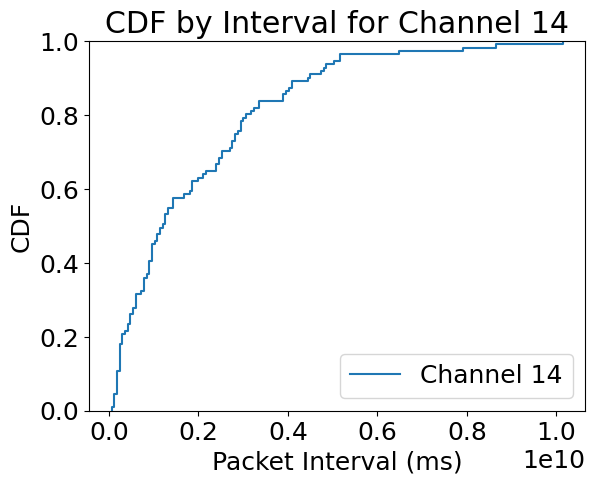

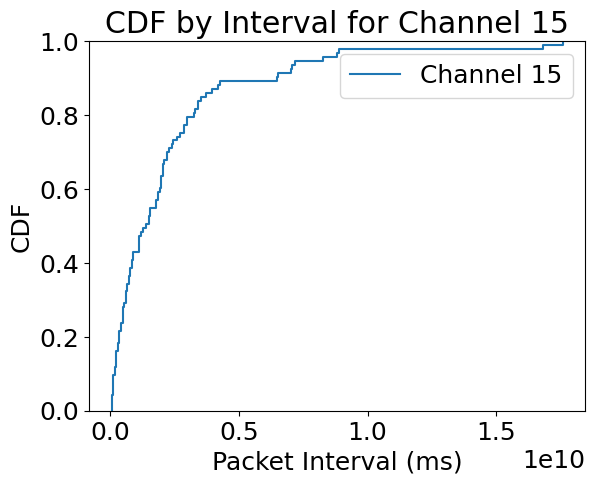

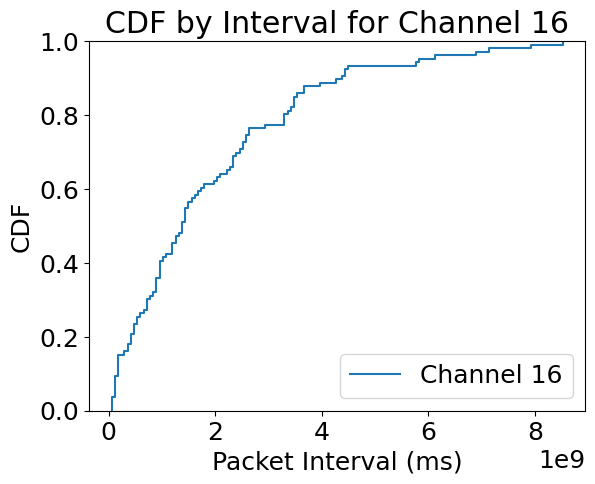

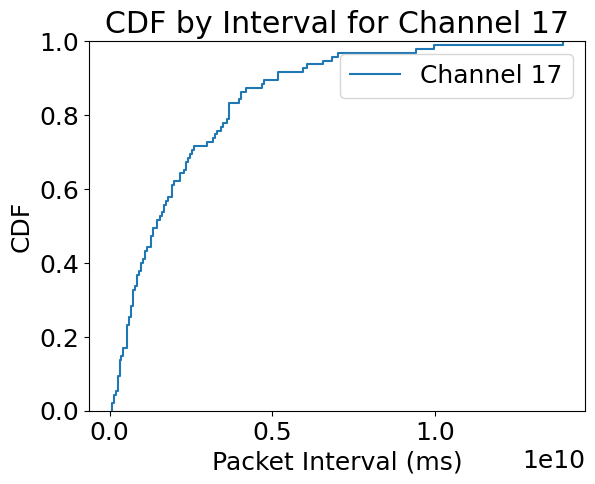

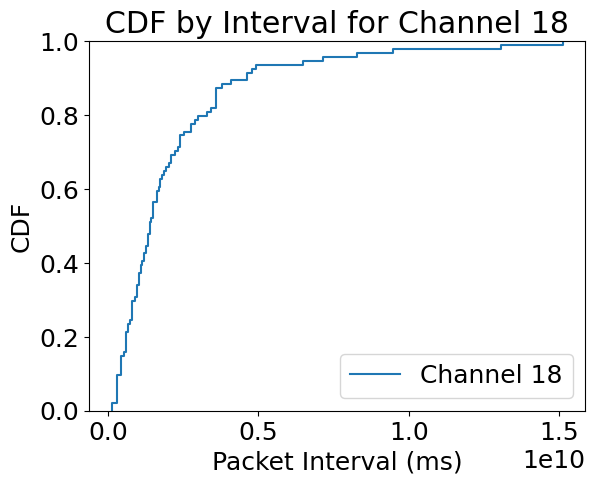

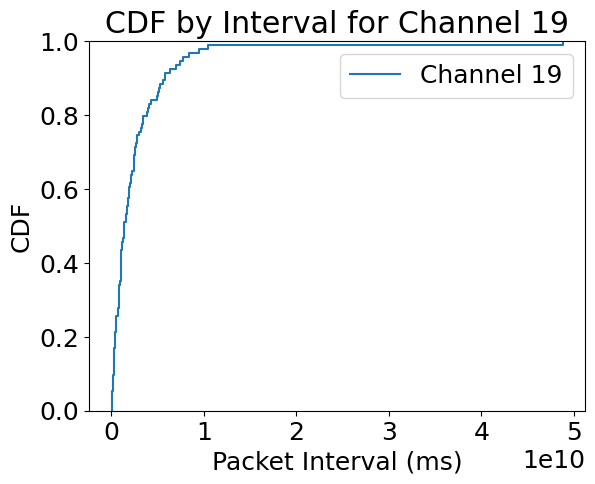

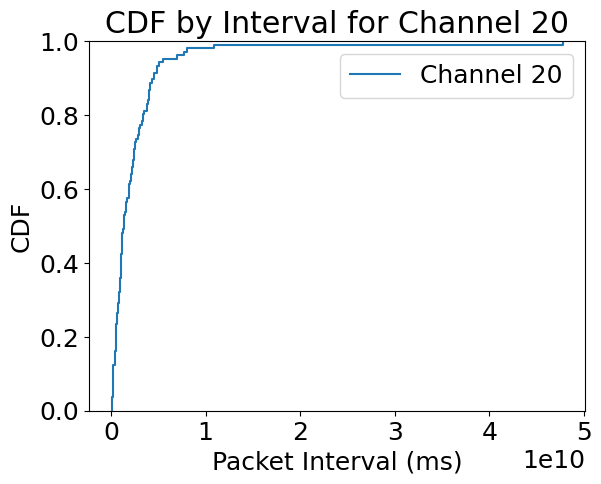

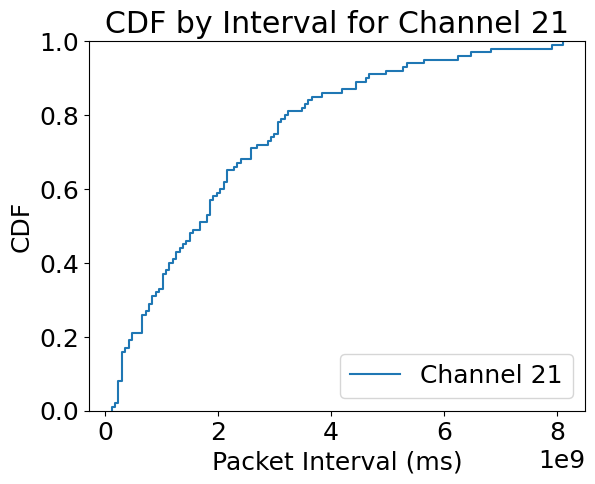

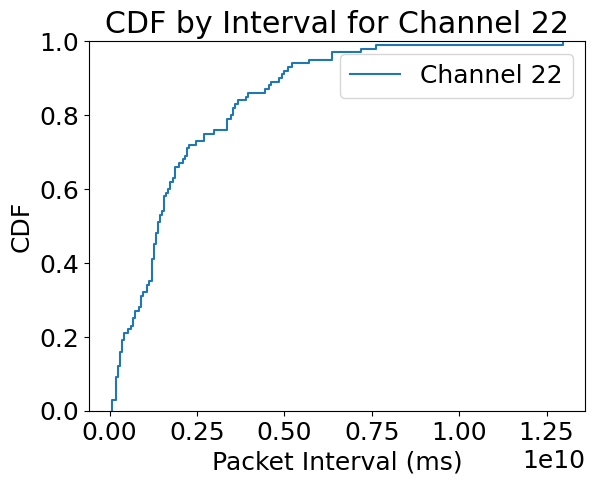

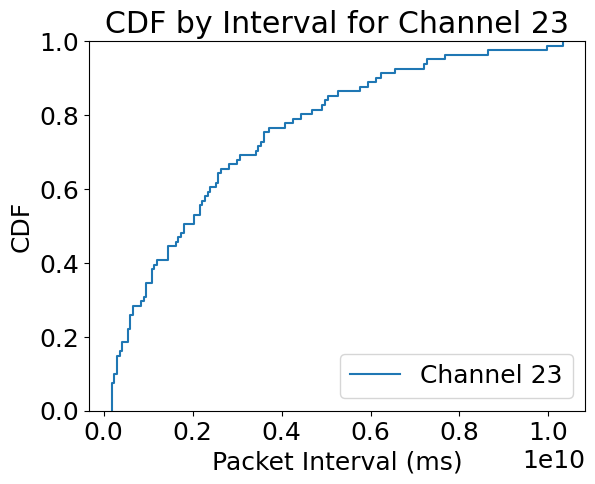

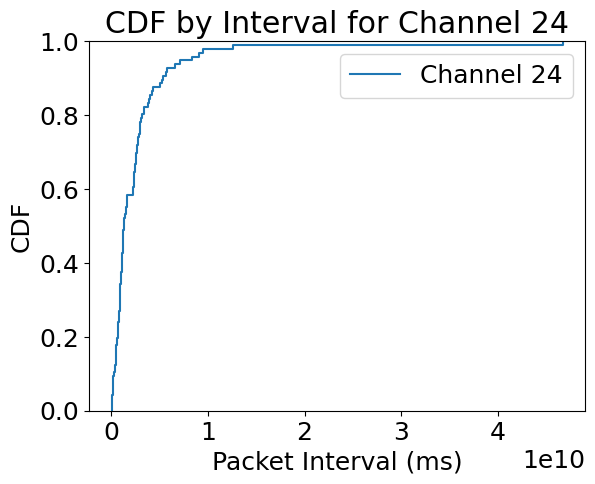

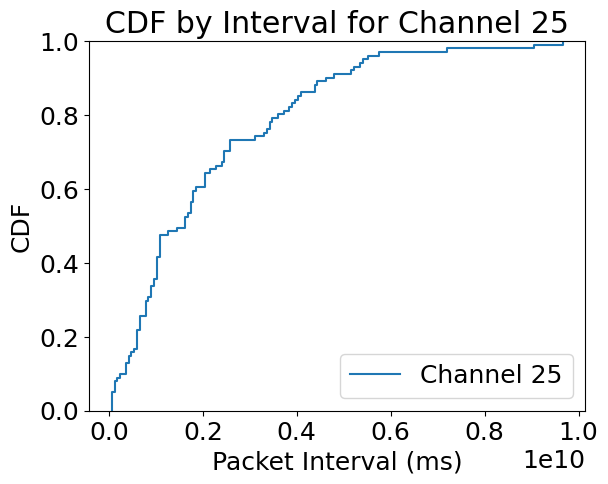

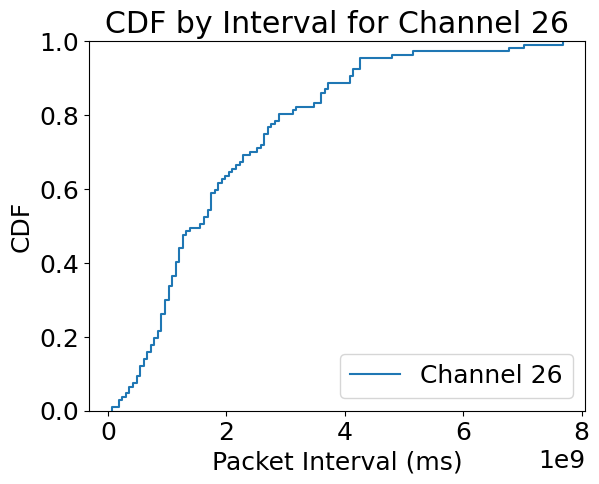

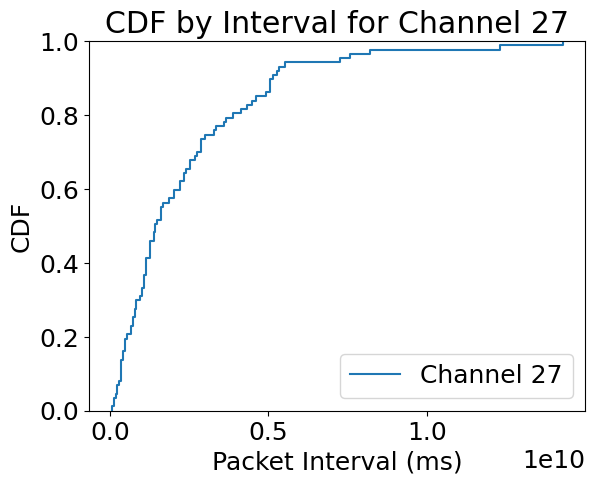

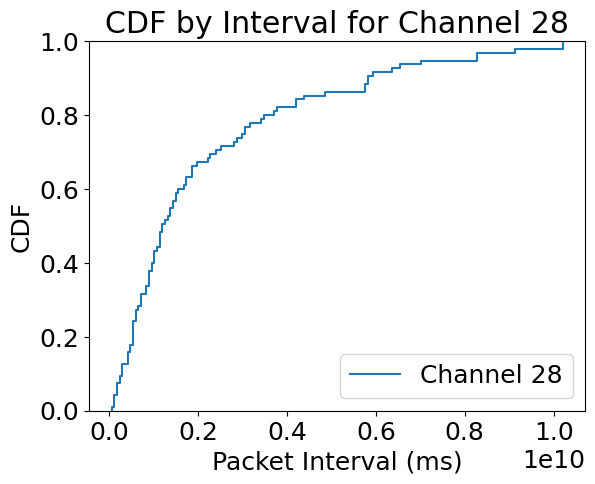

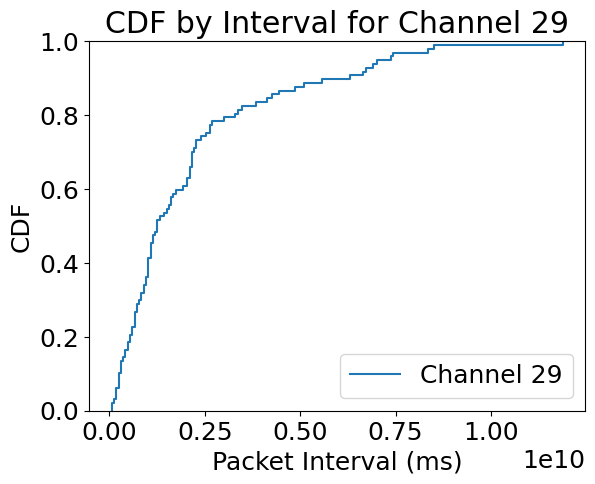

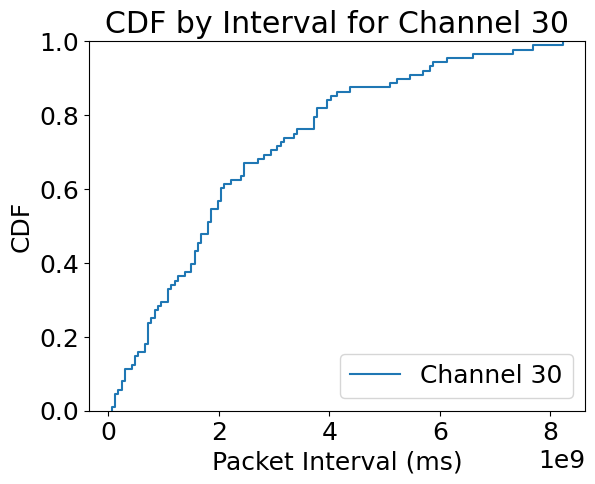

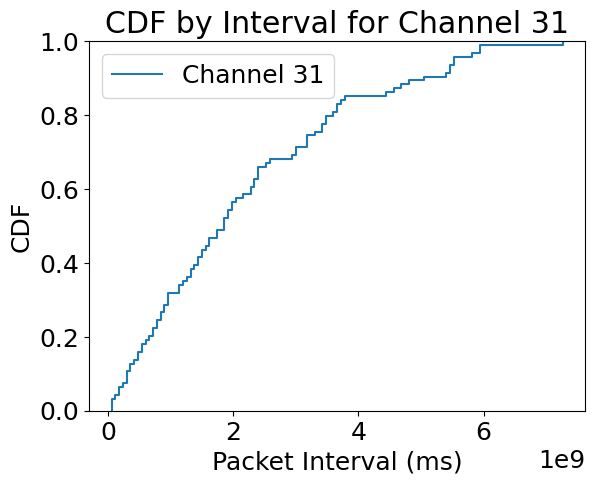

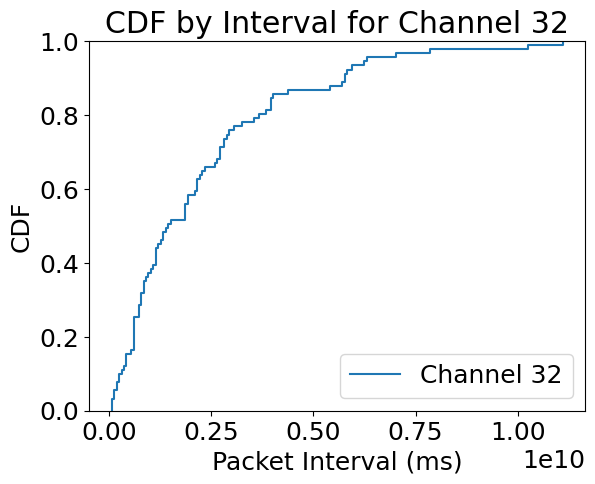

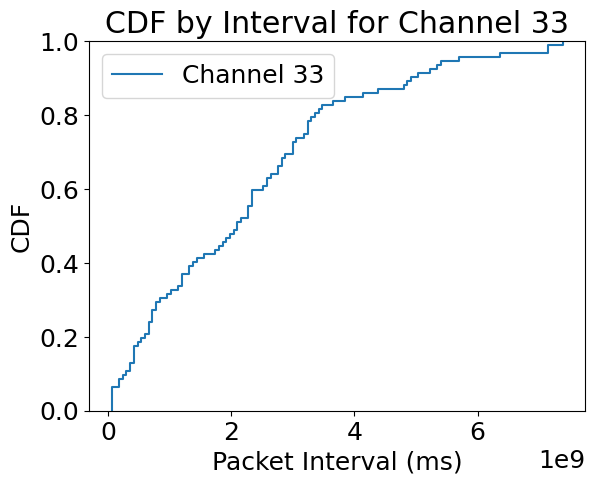

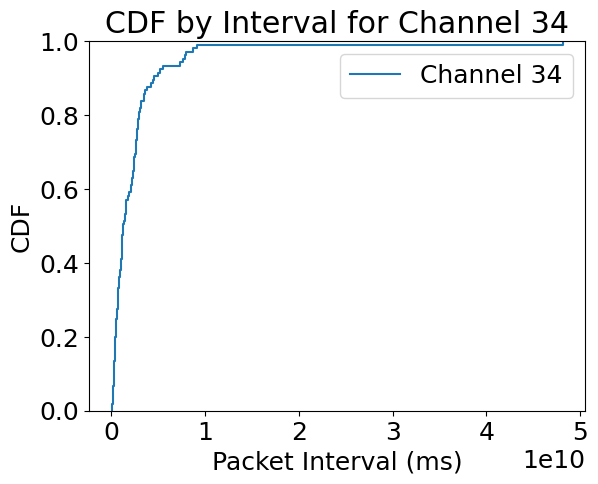

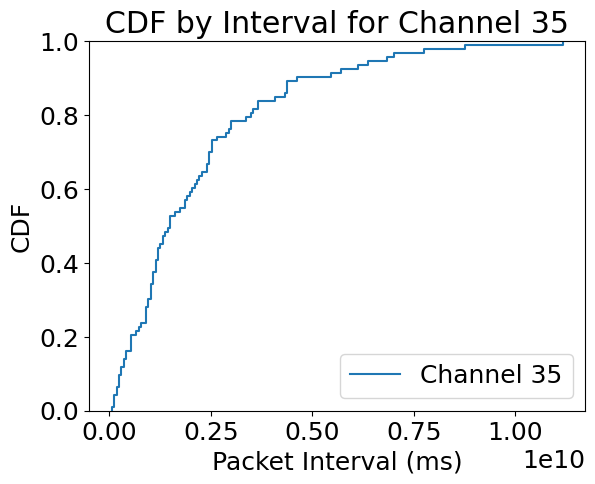

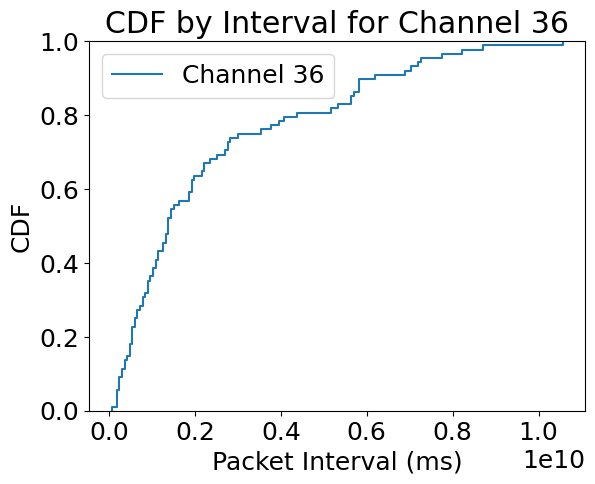

In [ ]:
# Group data by channel number
grouped_data = dfs['g1']['qos'].groupby('channel_index')

# Plot ECDF for each channel
for channel, group in grouped_data:
    # Calculate the time intervals between packets
    intervals = group['timedelta'].diff().dropna()

    # Plot the ECDF using seaborn.ecdfplot
    sns.ecdfplot(intervals, label=f'Channel {channel}')

    # Set axis labels and legend
    plt.xlabel('Packet Interval (ms)')
    plt.ylabel('CDF')
    plt.legend()
    plt.title('CDF by Interval for Channel {}'.format(channel))

    # Show plot
    plt.show()

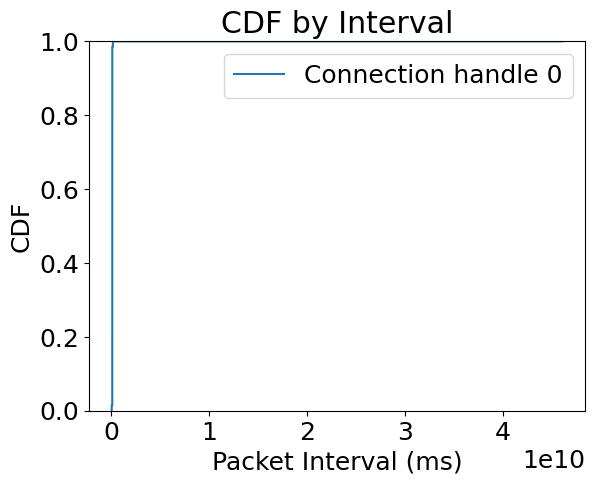

In [ ]:
# Group data by connection handle
grouped_data = dfs['g1']['vs'].groupby('conn_handle')

# Plot ECDF for each connection handle
for connectionhandle, group in grouped_data:
    # Calculate the time intervals between packets
    intervals = group['timedelta'].diff().dropna()

    # Plot the ECDF using seaborn.ecdfplot
    sns.ecdfplot(intervals, label=f'Connection handle {connectionhandle}')

    # Set axis labels and legend
    plt.xlabel('Packet Interval (ms)')
    plt.ylabel('CDF')
    plt.legend()
    plt.title('CDF by Interval')

    # Show plot
    plt.show()

In [ ]:
dfs['g1']['vs']

,time,conn_handle,cc,timedelta
0,959044,0,219,0 days 00:15:59.044000
1,959164,0,220,0 days 00:15:59.164000
2,959284,0,221,0 days 00:15:59.284000
3,959404,0,222,0 days 00:15:59.404000
4,1005484,0,94,0 days 00:16:45.484000
...,...,...,...,...
1770,1217464,0,68,0 days 00:20:17.464000
1771,1217584,0,69,0 days 00:20:17.584000
1772,1217704,0,70,0 days 00:20:17.704000
1773,1217824,0,71,0 days 00:20:17.824000


## Delay prob

In [ ]:
def over360(p):
    n=6
    P = np.array(
        [([0, 1.] + [0 for i in range(n-2)])]+[[1-p,0]+[p if i==j else 0 for j in range(n-2)] for i in range(n-2)]+[([0 for i in range(n-1)] + [1])],
        dtype='float64'
    ).T
    v_init = np.array(
        [1] + [0 for i in range(n-1)],
        dtype='float64'
    )
    n_event = int(datetime.timedelta(days=365*10).total_seconds() / 0.06)
    return ((np.linalg.matrix_power(P, n_event))@v_init)[-1]

In [ ]:
(dfs['g1']['qos']['crc_error_count'] + dfs['g1']['qos']['crc_ok_count']).idxmax()

262

In [ ]:
pd.set_option('display.max_columns', 100)
_df = dfs['g4']['qos']
_df.loc[_df['crc_error_count']+_df['crc_ok_count']>=2].T

KeyError: 'g4'

In [ ]:
worst_p = -1
worst_group = ''
worst_addr = ''
for group, df_group in dfs.items():
    for conn_handle, addr in sorted(group_handle2addr[group].items(), key=lambda x: x[1]):
        df_qos = df_group['qos'].query('conn_handle==@conn_handle')
        # s = df_group((df_group['qos']['conn_handle']==conn_handle)&(df_group['qos']['result']!='ok'))
        s = (df_qos['result']!='ok')
        p = s.sum() / s.count()
        worst_p = max(p, worst_p)
        if p==worst_p:
            worst_group = group
            worst_addr = addr
        print(f'group:{group}, conn handle:{conn_handle}, addr: {addr}, p: {p:.3e}, p(over360):{over360(p):.3e}')

print(worst_group, worst_addr)
print(f'worst p:{worst_p:.3e}, over360: {over360(worst_p):.3e}')

group:g1, conn handle:4, addr: C2:F9:E6:45:3F:81, p: 1.279e-02, p(over360):1.000e+00
group:g1, conn handle:3, addr: C9:0C:0C:7F:29:1C, p: 3.673e-03, p(over360):3.798e-01
group:g1, conn handle:5, addr: CB:F7:79:08:DE:5E, p: 6.297e-03, p(over360):9.837e-01
group:g1, conn handle:8, addr: CF:4E:70:1E:6F:B7, p: 9.497e-03, p(over360):1.000e+00
group:g1, conn handle:0, addr: D4:8F:05:A1:2A:82, p: 4.321e-03, p(over360):5.993e-01
group:g1, conn handle:7, addr: DC:74:D7:5F:3C:65, p: 3.665e-03, p(over360):3.771e-01
group:g1, conn handle:1, addr: DD:EA:33:21:73:01, p: 2.032e-03, p(over360):4.373e-02
group:g1, conn handle:6, addr: E9:4F:A7:84:CA:42, p: 4.857e-03, p(over360):7.675e-01
group:g1, conn handle:10, addr: EB:B1:33:14:CE:B7, p: 5.872e-03, p(over360):9.556e-01
group:g1, conn handle:9, addr: EE:F3:7D:5B:8A:B5, p: 2.329e-03, p(over360):7.439e-02
group:g1, conn handle:2, addr: F7:D5:DD:39:68:28, p: 8.005e-03, p(over360):1.000e+00
group:g2, conn handle:4, addr: C9:E2:DF:C0:DB:3B, p: 1.109e-02, 